In [350]:
import fiona
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from time import time
from tqdm import tqdm
import xarray as xr
import torch
import torch.nn as nn
import matplotlib.colors as colors
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

seed = 1234
np.random.seed(seed)

## 1. Read Xarray Files


In [351]:
def get_filenames(directory):
    filenames = sorted(os.listdir(directory))
    return [f for f in filenames if f.endswith(".nc")]


def get_path(directory, filename):
    return os.path.join(directory, filename)


def get_basename(path):
    return os.path.basename(path)


def get_month_year(file_name, dtype="ppt"):
    """Get month and year from file name"""
    if dtype == "ppt":
        time = pd.Timestamp("-".join(file_name.split(".")[0].split("_")[1:]))
        month, year = time.month, time.year
    elif dtype == "sst":
        year, month = file_name.split(".")[-2][-6:-2], file_name.split(".")[-2][-2:]
        month, year = int(month), int(year)
    else:
        print(f"dtype {dtype} not implemented. Use ppt or sst.")
        month, year = None, None
    return month, year


def read_xr(path, dtype="ppt"):
    """Read xarray file"""
    file_data = xr.load_dataset(path, engine="netcdf4")
    file_name = get_basename(path)
    month, year = get_month_year(file_name, dtype)
    xr_data = [file_name, year, month]

    if dtype == "ppt":
        file_data = file_data.rename_vars(
            {list(file_data.keys())[1]: "ppt", "longitude": "lon", "latitude": "lat"}
        )

        # Coarsen data to reduce resolution
        file_data = file_data.coarsen(latitude=4, longitude=4, boundary="trim").mean()
        #         file_data = file_data.sel(longitude=slice(-300, -100))

        ##Slice for west coast
        file_data = file_data.sel(longitude=slice(0, 150))

        xr_data.append(file_data.ppt.values)
        columns = list("FYMD")
        columns[-1] = "ppt"

    elif dtype == "sst":
        # Coarsen data to reduce resolution
        #         file_data = file_data.coarsen(lat = 4, lon = 4, boundary = "trim").mean()

        ##Slice for west coast
        #         file_data = file_data.sel(lon=slice(100, 400))

        xr_data.extend([file_data.sst.values, file_data.ssta.values])
        columns = list("FYMDA")
        columns[-2], columns[-1] = "sst", "ssta"

    else:
        print(f"dtype {dtype} not implemented. Use ppt or sst.")

    longitude, latitude = file_data.lon.values, file_data.lat.values
    return xr_data, longitude, latitude, columns


def load_data(directory, dtype="ppt"):
    """Load directory files in a pandas dataframe"""
    filenames = get_filenames(directory)
    data_info_list = []
    for i, file_name in tqdm(enumerate(filenames)):
        path = get_path(directory, file_name)
        xr_data, longitude, latitude, columns = read_xr(path, dtype)
        data_info_list.append(xr_data)
    df = pd.DataFrame([p for p in data_info_list], columns=columns)
    return df, latitude, longitude

#### `Change ppt_directory and sst_directory based on your directories`


In [352]:
ppt_directory = "data/ppt-nc-1895-2020"
sst_directory = "data/ERSST"

In [353]:
### Load ppt data
ppt_df, lat, lon = load_data(ppt_directory, dtype="ppt")

759it [00:10, 70.81it/s]


### PPT Levels in different U.S. States


In [354]:
def show_states(west_coast=True, state_file="States/cb_2018_us_state_20m.shp"):
    shape = fiona.open(state_file)
    for s in shape:
        pts = s["geometry"]["coordinates"]
        for p in pts:
            state = np.array(p).squeeze()
            if state[:, 1].min() < 50 and state[:, 1].min() > 22:
                if not west_coast:
                    plt.plot(state[:, 0], state[:, 1], color="black")
                elif np.max(state[:, 0]) < -100:  # plot only west coast
                    plt.plot(state[:, 0], state[:, 1], color="black")

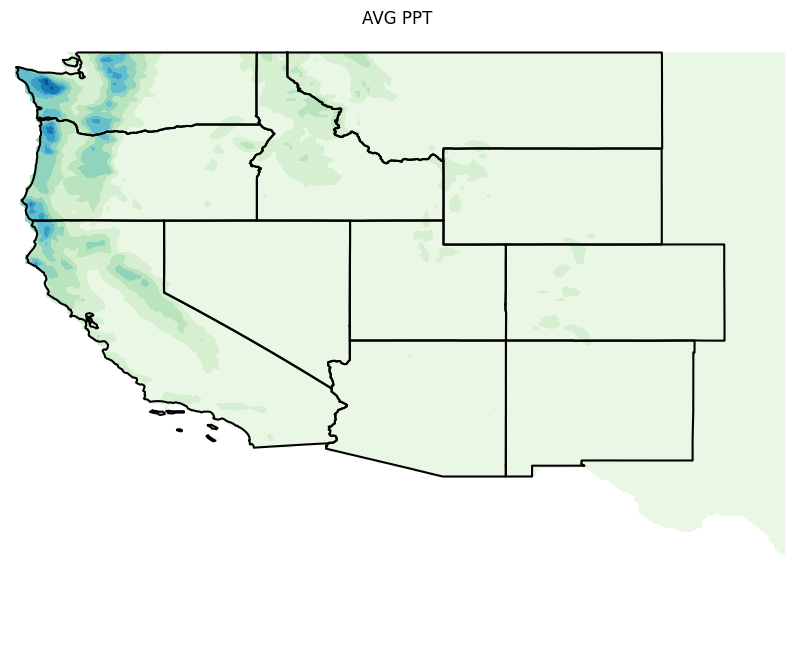

In [355]:
avg_ppt = ppt_df["ppt"].mean()

plt.figure(figsize=(10, 8))
xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, avg_ppt, cmap="GnBu")
show_states()
plt.axis("off")
plt.title("AVG PPT")
plt.show()
plt.close()

In [356]:
### Load sst data
sst_df, _, _ = load_data(sst_directory, dtype="sst")
sst_df

1644it [00:05, 278.39it/s]


,F,Y,M,sst,ssta
0,ersst.v5.188001.nc,1880,1,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1,ersst.v5.188002.nc,1880,2,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
2,ersst.v5.188003.nc,1880,3,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
3,ersst.v5.188004.nc,1880,4,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
4,ersst.v5.188005.nc,1880,5,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
...,...,...,...,...,...
1639,ersst.v5.201608.nc,2016,8,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1640,ersst.v5.201609.nc,2016,9,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1641,ersst.v5.201610.nc,2016,10,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1642,ersst.v5.201611.nc,2016,11,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...


### SST Levels


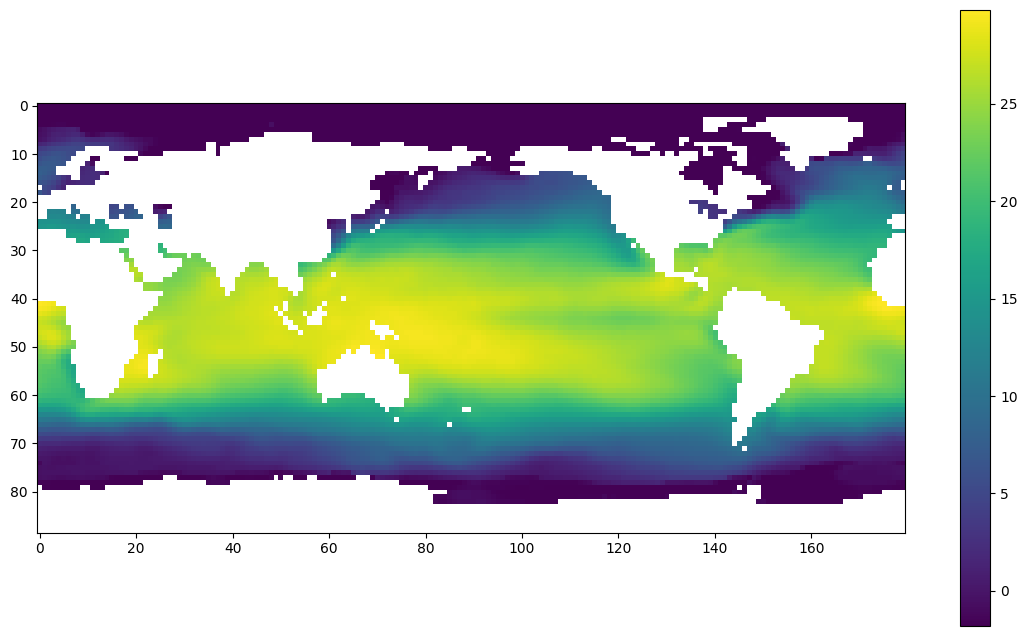

(1644,)

In [357]:
plt.figure(figsize=(14, 8))
sst_example = sst_df["sst"].iloc[0]
plt.imshow(np.flipud(sst_example.reshape(sst_example.shape[-2], sst_example.shape[-1])))
plt.colorbar()
plt.show()
sst_df["sst"].shape

In [358]:
## Check shapes of ppt and sst
sst_df["sst"].iloc[0].shape, ppt_df["ppt"].iloc[0].shape

((1, 1, 89, 180), (155, 150))

In [359]:
# get rainfall month and year
rain_row = ppt_df.iloc[0]
m, y = rain_row["M"], rain_row["Y"]

# get sst month and year
sst_row = sst_df[(sst_df["M"] == m) & (sst_df["Y"] == y)]  # bitmask filters for month and year
index_position = sst_row.index[0]  # index returns Index object, so we need to get the first element

# if index_position < 24:
#     # do something, though this should never happen cuz sst starts far earlier

prev24 = sst_df.iloc[index_position - 24 : index_position]

In [360]:
import pandas as pd

# Sample DataFrame
data = {
    "month": [1, 5, 7, 5, 12],
    "year": [2020, 2021, 2021, 2022, 2020],
    "data": ["A", "B", "C", "D", "E"],  # Additional data column for illustration
}
df = pd.DataFrame(data)

# Your target month and year
target_month = 5
target_year = 2021

# Create a boolean mask to filter the DataFrame
mask = (df["month"] == target_month) & (df["year"] == target_year)

# Apply the mask to the DataFrame
filtered_df = df[mask]

# Display the filtered DataFrame
print(filtered_df)

   month  year data
1      5  2021    B


## 2. Combine SST and PPT


In [361]:
df = sst_df.merge(ppt_df, on=["Y", "M"], suffixes=("_sst", "_ppt"), how="inner")

## 3. Add Temporal Features


In [362]:
def add_time(df):
    """Add Time Column"""
    min_year = np.min(df["Y"])
    df["T"] = (df["Y"] - min_year) * 12 + df["M"]
    return df


def add_season(df):
    """adds Season Column (0 for months 1,2,3 and 1 for months 10,11,12)"""
    df["season"] = ((df["M"] - 1) // 4).astype(bool).astype(int)
    return df


df = add_season(add_time(df))
df.to_csv("data/df.csv", index=False)

### ppt has data for only months 1,2,3,10,11,12. While sst has all months.


## 4. Add Clusters


In [363]:
clusters = np.load("clusters.npy")

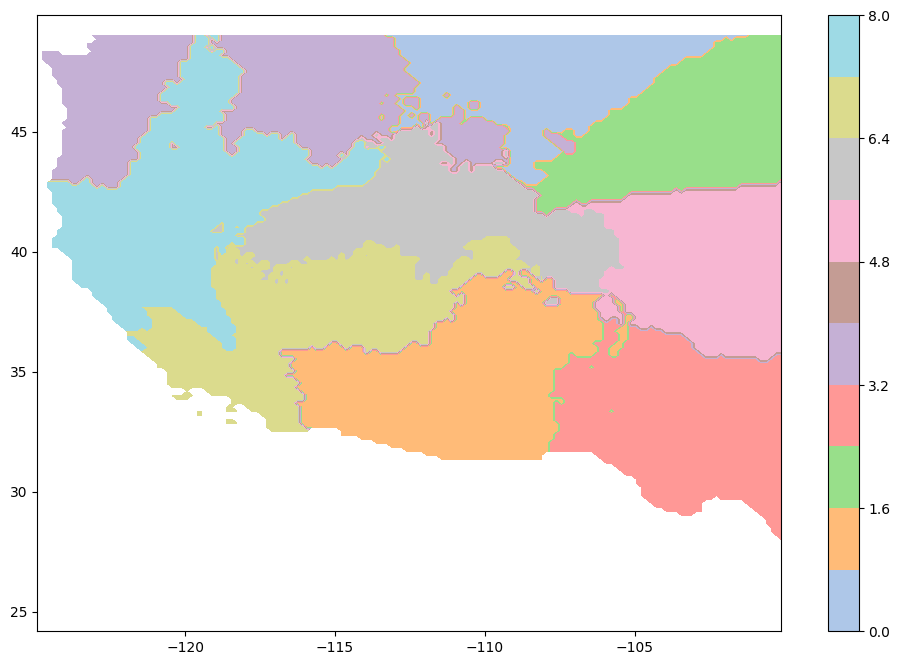

np.unique(clusters):  [ 0.  1.  2.  3.  4.  5.  6.  7.  8. nan]


In [364]:
plt.figure(figsize=(12, 8))
xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, clusters, levels=10, cmap="tab20")
plt.colorbar()
plt.show()
print("np.unique(clusters): ", np.unique(clusters))

In [365]:
def average_clusters(image, cluster_array, return_image=True):
    """Average the values of each cluster in the image"""
    unique_clusters = np.unique(cluster_array)  # Find unique cluster labels

    if return_image:
        # Initialize an array to store the average values
        averaged_image = np.zeros_like(image, dtype=float)
    else:
        cluster_averages = []

    for cluster_label in unique_clusters:
        # Mask the original image with the current cluster label
        masked_image = np.where(cluster_array == cluster_label, image, 0)

        # Calculate the average value for the current cluster
        cluster_size = np.sum(cluster_array == cluster_label)
        cluster_average = np.sum(masked_image) / cluster_size

        if return_image:
            # Replace pixels in the averaged image with the cluster average
            averaged_image += np.where(
                cluster_array == cluster_label, cluster_average, 0
            )
        else:
            cluster_averages.append(cluster_average)

    return averaged_image if return_image else np.array(cluster_averages)


avg_clusters = average_clusters(df.iloc[0].ppt, clusters)
avg_clusters

/var/folders/56/lnrgwj295yq6l00hqdbfzfmr0000gn/T/ipykernel_1658/790362116.py:17: RuntimeWarning: invalid value encountered in divide
  cluster_average = np.sum(masked_image) / cluster_size


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

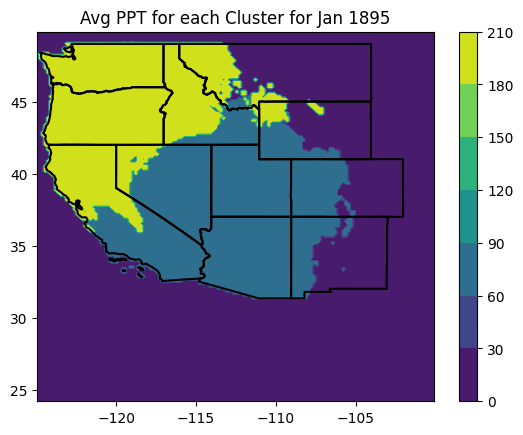

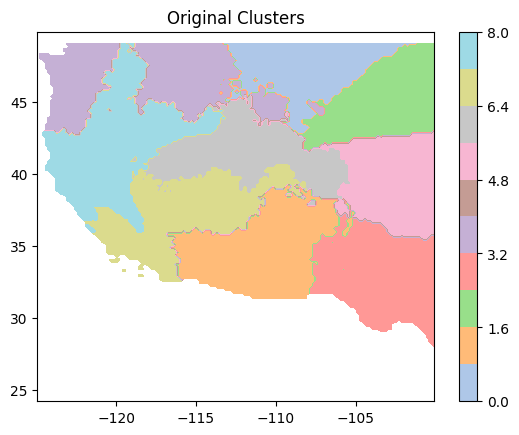

In [366]:
plt.contourf(xx, yy, avg_clusters)
plt.colorbar()
show_states()
plt.title("Avg PPT for each Cluster for Jan 1895")
plt.show()

xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, clusters, levels=10, cmap="tab20")
plt.colorbar()
plt.title("Original Clusters")
plt.show()

In [367]:
df["ppt_cluster"] = df["ppt"].apply(lambda x: average_clusters(x, clusters))
df["ppt_cluster_vector"] = df["ppt"].apply(
    lambda x: average_clusters(x, clusters, return_image=False)[:-1]
)

/var/folders/56/lnrgwj295yq6l00hqdbfzfmr0000gn/T/ipykernel_1658/790362116.py:17: RuntimeWarning: invalid value encountered in divide
  cluster_average = np.sum(masked_image) / cluster_size
/var/folders/56/lnrgwj295yq6l00hqdbfzfmr0000gn/T/ipykernel_1658/790362116.py:17: RuntimeWarning: invalid value encountered in divide
  cluster_average = np.sum(masked_image) / cluster_size


## 5. Add Quantiles


In [368]:
def get_quantiles(df, cluster=True):

    vector = df.ppt_cluster_vector if cluster else df.ppt

    ppt_vector = np.stack(vector.apply(lambda x: x.reshape(-1))).T
    q1 = np.quantile(ppt_vector, 0.25, axis=1, keepdims=True).flatten()
    q2 = np.quantile(ppt_vector, 0.5, axis=1, keepdims=True).flatten()
    q3 = np.quantile(ppt_vector, 0.75, axis=1, keepdims=True).flatten()
    return q1, q2, q3


q1, q2, q3 = get_quantiles(df)
q1

array([ 9.5338221 , 12.17312131,  9.24412442,  7.47316639, 94.40965887,
        8.27551748, 25.58297759, 13.8765325 , 42.52929087])

In [369]:
def get_quantized(x, q1, q2, q3):
    output = np.zeros_like(x)
    output[x <= q1] = 1
    q2_arr = np.array(x > q1) * np.array(x <= q2)
    q3_arr = np.array(x > q2) * np.array(x <= q3)
    output[q2_arr] = 2
    output[q3_arr] = 3
    output[x > q3] = 4
    return output

In [370]:
df["ppt_cluster_vector_quantized"] = df["ppt_cluster_vector"].apply(
    lambda x: get_quantized(x, q1, q2, q3)
)
df[["T", "M", "ppt_cluster_vector_quantized"]]

,T,M,ppt_cluster_vector_quantized
0,1,1,"[4.0, 4.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0]"
1,2,2,"[3.0, 3.0, 3.0, 4.0, 1.0, 4.0, 2.0, 3.0, 2.0]"
2,3,3,"[2.0, 1.0, 3.0, 1.0, 1.0, 2.0, 3.0, 3.0, 2.0]"
3,10,10,"[1.0, 3.0, 1.0, 4.0, 1.0, 3.0, 1.0, 1.0, 1.0]"
4,11,11,"[4.0, 4.0, 4.0, 4.0, 2.0, 3.0, 3.0, 2.0, 1.0]"
...,...,...,...
727,1454,2,"[1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 1.0, 2.0, 1.0]"
728,1455,3,"[3.0, 1.0, 4.0, 2.0, 4.0, 4.0, 4.0, 3.0, 4.0]"
729,1462,10,"[4.0, 1.0, 4.0, 2.0, 4.0, 2.0, 4.0, 2.0, 4.0]"
730,1463,11,"[2.0, 3.0, 3.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0]"


## Organizing Data into y_labels and x_input

Want to create a dataframe of sea surface temperature input for each cluster precipitation estimation (1, 2, 3, or 4).
The input data should be 24 months worth of sea surface temperature data. This data is stored in a quadruple vector.
For each a ppt_cluster_vector quantity, grab the last 24 months of "sst" quadruple vector data information.
to test.


### Organizing Y Labels and processing ppt clusters


In [371]:
y_labels = df.loc[:,["Y", "M", "ppt_cluster_vector_quantized"]]
y_labels = y_labels.rename(columns={"M": "month", "Y": "year"})
y_labels["date"] = pd.to_datetime(y_labels[["month","year"]].assign(day=1))
y_labels["date"] = y_labels['date']

y_labels.drop(["month"], axis=1, inplace=True)
y_labels.drop(["year"], axis=1, inplace=True)
y_labels.set_index("date", inplace=True)

ppt_data = np.array(y_labels["ppt_cluster_vector_quantized"]) - 1
# get all 9 clusters in a list, where each cluster is the ith column in ppt_data
clusters = [np.array([x[i] for x in ppt_data]) for i in range(len(ppt_data[0]))]
clusters = np.array(clusters)


In [372]:
sst_condensed = sst_df.loc[:,["Y", "M", "sst"]]
sst_condensed = sst_condensed.rename(columns={"M": "month", "Y": "year"})
sst_condensed["date"] = pd.to_datetime(sst_condensed[["month","year"]].assign(day=1))
sst_condensed["date"] = sst_condensed['date']

sst_condensed.drop(["month"], axis=1, inplace=True)
sst_condensed.drop(["year"], axis=1, inplace=True)
sst_condensed.set_index("date", inplace=True)


### Process sst data for forest tree classification on entire dataset


In [373]:
x_input_rows = []
for date in y_labels.index:
    start_date = date - pd.DateOffset(months=23)
    end_date = date
    
    sst_in_range = np.array(sst_condensed.loc[start_date:end_date, 'sst'].tolist()) # shape here is (24, 1, 1, 89, 180)
    IO_TP_sst_in_range = sst_in_range.flatten() #1 x 384480
    sst_in_range = sst_in_range[~np.isnan(sst_in_range)] # 263712
    
    x_input_rows.append({'start date': start_date, 'end date' : end_date, 'sst rows': sst_in_range})

x_input = pd.DataFrame(x_input_rows)
x_input["start date"] = x_input["start date"].dt.to_period('M')
x_input["end date"] = x_input["end date"].dt.to_period('M')
sst_data_all = np.array([xi.tolist() for xi in np.array(x_input[:]["sst rows"])])

### Process data for PCA pre-processing with regions

We need to split the data into the following regions, so we use array slicing

![](PCA_regions.png)

Now that we have the regions, we'll split the sst data into regions using these approximate coordinates we have estimated. Once the data is separated into regions, we can use principal component analysis to reduce dimensionality and assess the effect on random forest training quality.


In [374]:
def process_sst_data(raw_sst_data, pca_components, x_start, x_end, y_start, y_end):
    """Take raw SST data, which is a DataFrame organized by data, and region boundaries
       Process data and outputs a numpy array which has been decomposed with PCA
       Original shape is (24, 1, 1, 89, 180)
       Slice according to region limits
       Flatten the data
       """
    
    curr_region_rows = []

    for date in y_labels.index:
        start_date = date - pd.DateOffset(months=23)
        end_date = date
        # slice sst data according to region limits and convert to array
        sst_in_range = np.array(raw_sst_data.loc[start_date:end_date, 'sst'].tolist())[:, :, :, y_start:y_end, x_start:x_end]
        # data shape is (24, 1, 1, y, x) and we want to flatten to a 1D array
        sst_in_range = sst_in_range.flatten()
        # remove NaN values
        sst_in_range = sst_in_range[~np.isnan(sst_in_range)]
        # append to the list of rows
        curr_region_rows.append({'start date': start_date, 'end date' : end_date, 'sst rows': sst_in_range})

    # convert to DataFrame
    curr_region_input = pd.DataFrame(curr_region_rows)
    # convert dates to period
    curr_region_input["start date"] = curr_region_input["start date"].dt.to_period('M')
    curr_region_input["end date"] = curr_region_input["end date"].dt.to_period('M')
    # convert to final raw numpy array with only the sst data
    curr_region_data_all = np.array([xi.tolist() for xi in np.array(curr_region_input[:]["sst rows"])])


    # apply PCA to the data
    pca = PCA(n_components=pca_components)
    pca_data = pca.fit_transform(curr_region_data_all)
    return pca_data

# IO -> data[34:55][10:67]
# TP -> data[34:55][55:143]
# NP -> data[11:32][59:128]
# WP -> data[28:49][55:84]

TP = process_sst_data(sst_condensed, pca_components=2, x_start=55, x_end=144, y_start=34, y_end=56)
IO = process_sst_data(sst_condensed, 2, 10, 68, 34, 56)
WP = process_sst_data(sst_condensed, 2, 55, 85, 28, 50)
NP = process_sst_data(sst_condensed, 2, 59, 129, 11, 33)
sst_pca = np.hstack((IO, TP, WP, NP))

sst_pca.shape

(732, 8)

In [375]:
def get_cluster_data(ind):
    X_train, X_test, y_train, y_test = train_test_split(sst_pca, clusters[ind], test_size=0.1, random_state=4)
    return X_train, X_test, y_train, y_test

## Training a Random Forest

We now have our nine label clusters and our input rows as well (which contain the flattened sea surface temperature data across the globe, excluding land coordinates). We'd like to train a random forest model on these as the first iteration of trying to fit a model.


In [376]:
accuracies = []
conf_preds = []
conf_labels = []

for i in range(len(clusters)):
    X_train, X_test, y_train, y_test = get_cluster_data(i)

    rf = RandomForestClassifier(max_depth=1, min_samples_leaf=100, n_estimators=200) # since there are only 4 possible outputs, we use a Classifier
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    accuracies.append(accuracy_score(y_test, y_pred))
    conf_preds.append(y_pred)
    conf_labels.append(y_test)
    print(f"Accuracy for cluster {i}: {accuracies[i]}")

Accuracy for cluster 0: 0.3918918918918919
Accuracy for cluster 1: 0.1891891891891892
Accuracy for cluster 2: 0.40540540540540543
Accuracy for cluster 3: 0.36486486486486486
Accuracy for cluster 4: 0.2972972972972973
Accuracy for cluster 5: 0.44594594594594594
Accuracy for cluster 6: 0.20270270270270271
Accuracy for cluster 7: 0.3783783783783784
Accuracy for cluster 8: 0.33783783783783783


### Graphing results


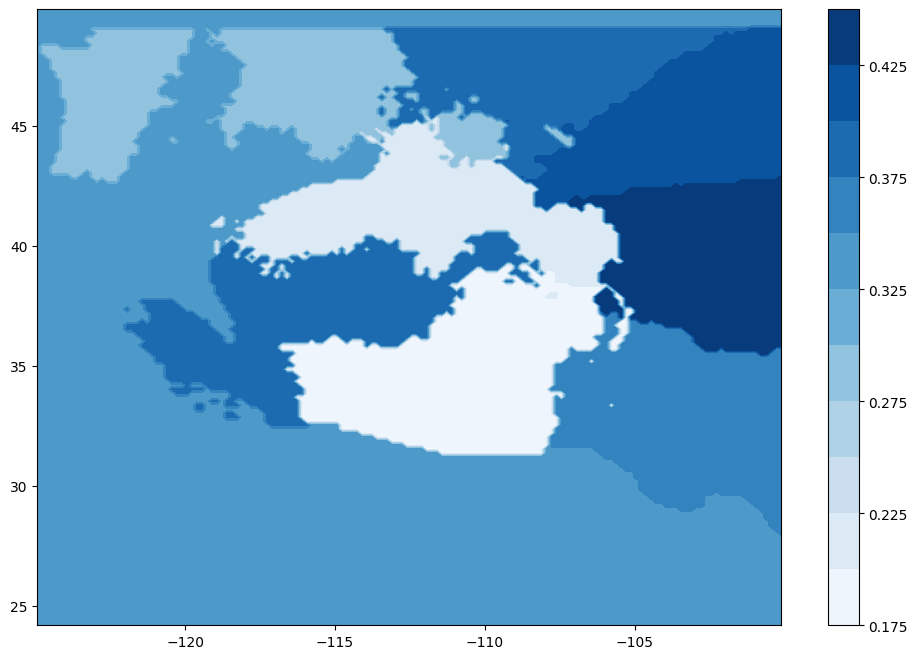

In [377]:
# clusters is 155x150 grid of values 0-8 -> convert to grid of same size with accuracy values
accuracies = np.array(accuracies)
cluster_map = np.load("clusters.npy")
cluster_map = np.where(np.isnan(cluster_map), -1, cluster_map)  # replace NaNs with -1
cluster_map = cluster_map.astype(int) # convert to integer
# replace all cluster numbers with their corresponding accuracy 
cluster_map = accuracies[cluster_map] # can change this back to floats and use NaNs if needed

plt.figure(figsize=(12, 8))
xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, cluster_map, levels=10, cmap="Blues")
plt.colorbar()
plt.show()


### Confusion Matrix

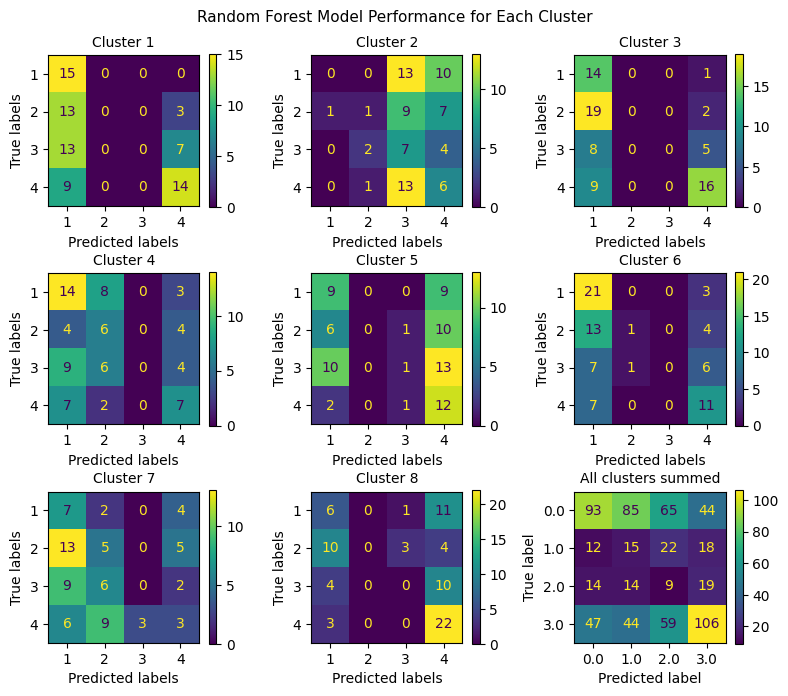

In [404]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrices(predictions, correct_labels, title=""):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,7))
    spec = fig.add_gridspec(2, 4)
    flattened_axes = axes.flatten()
    for i in range(8):
        a = flattened_axes[i]
        ConfusionMatrixDisplay.from_predictions([int(x + 1) for x in correct_labels[i]], [int(x + 1) for x in predictions[i]], ax=a)
        a.set_title(label=f'Cluster {i+1}', fontdict={'fontsize':10})
        a.set_xlabel(xlabel='Predicted labels',fontdict={'fontsize':10})
        a.set_ylabel(ylabel='True labels',fontdict={'fontsize':10})
        i += 1
    ConfusionMatrixDisplay.from_predictions(np.array(predictions).flatten(),np.array(correct_labels).flatten(), ax=flattened_axes[8])
    flattened_axes[8].set_title(label="All clusters summed", fontdict={'fontsize':10})
    fig.suptitle(title, fontsize=11)
    plt.tight_layout()  
    plt.show()

plot_confusion_matrices(conf_preds, conf_labels, "Random Forest Model Performance for Each Cluster")

## Testing Hyperparameters

Use GridSearchCV library to test different values for different parameters


In [379]:
params = {
    'max_depth': [1,2,3,5,10,20, 50, 100, 150, 200, 500, None],
    'min_samples_leaf': [1, 5, 10, 20, 50, 100, 200, 500],
    'n_estimators': [10,25,30,50,100,200]
}

# Assuming we have a list of clusters called 'clusters'
# and a function 'get_cluster_data' that returns X_train and y_train for a given cluster
best_params = {}

for i in range(len(clusters)):
    X_train, _, y_train, _ = get_cluster_data(i)
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator=rf,
                            param_grid=params,
                            cv = 4,
                            n_jobs=-1, verbose=1, scoring="accuracy")

    grid_search.fit(X_train, y_train)
        
        # Store the best parameters for the current cluster
    best_params[i] = grid_search.best_params_
    best_score = grid_search.best_score_
    best_esty = grid_search.best_estimator_
    print(f"best accuracy cluster {i}: {best_score}")
    print(f"best estimators cluster {i}: {best_esty}")
    print(f"best params for cluster {i}: {best_params[i]}")


Fitting 4 folds for each of 576 candidates, totalling 2304 fits
best accuracy cluster 0: 0.3845343680709534
best estimators cluster 0: RandomForestClassifier(min_samples_leaf=50, n_estimators=200)
best params for cluster 0: {'max_depth': None, 'min_samples_leaf': 50, 'n_estimators': 200}
Fitting 4 folds for each of 576 candidates, totalling 2304 fits
best accuracy cluster 1: 0.32215447154471544
best estimators cluster 1: RandomForestClassifier(max_depth=1, min_samples_leaf=20, n_estimators=30)
best params for cluster 1: {'max_depth': 1, 'min_samples_leaf': 20, 'n_estimators': 30}
Fitting 4 folds for each of 576 candidates, totalling 2304 fits
best accuracy cluster 2: 0.4163710273466371
best estimators cluster 2: RandomForestClassifier(max_depth=1, n_estimators=25)
best params for cluster 2: {'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 25}
Fitting 4 folds for each of 576 candidates, totalling 2304 fits
best accuracy cluster 3: 0.3343865484109387
best estimators cluster 3: Ran

## Trying Neural Network

Creating and training a logistic regression model


#### Model


In [380]:
# change to built in methods
class RainPrediction(nn.Module):
    def __init__(self, num_regions, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Dropout(0.05),
            nn.Linear(num_regions, 20),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(20, num_classes)
        )

    def forward(self, x):
        return self.model(x)
    

#### Training


In [381]:
def gradient_descent(model, loss_func, train_dataset, valid_dataset, optimizer, steps=5000, batch_size=64):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    losses = []
    valid_losses = []
    for step in tqdm(range(steps)):
        model.train()
        running_loss = 0.0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            loss = loss_func(model(x_batch), y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)

        model.eval()
        running_valid_loss = 0.0
        with torch.no_grad():
            for x_valid_batch, y_valid_batch in valid_loader:
                valid_loss = loss_func(model(x_valid_batch), y_valid_batch)
                running_valid_loss += valid_loss.item()
        avg_valid_loss = running_valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

        if (step + 1) % 10 == 0:
            print(f"Step {step+1}/{steps}, Training Loss: {avg_loss}, Validation Loss: {avg_valid_loss}")

    print(f"Final training loss: {losses[-1]}")
    print(f"Final validation loss: {valid_losses[-1]}")

    return losses, valid_losses


def calculate_accuracy(model, x, y):
    model.eval()
    with torch.no_grad():
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        return correct / total, predicted

# Iterate for all 8 clusters
nn_train_predictions_all_clusters = []
nn_test_predictions_all_clusters = []
nn_train_labels_all_clusters = []
nn_test_labels_all_clusters = []

for i in range(8):
    print(f"\nBegin training model for cluster {i+1}")
    # Get data for this cluster
    X_train, X_test, y_train, y_test = get_cluster_data(i)

    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Initialize the model and optimizer
    model = RainPrediction(X_train.shape[1], 4)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Run the training
    losses, valid_losses = gradient_descent(
        model, nn.CrossEntropyLoss(), train_dataset, test_dataset, optimizer, steps=150
    )

    train_accuracy, nn_train_predictions = calculate_accuracy(model, X_train_tensor, y_train_tensor)
    test_accuracy, nn_test_predictions = calculate_accuracy(model, X_test_tensor, y_test_tensor)

    nn_train_predictions_all_clusters.append(nn_train_predictions.tolist())
    nn_test_predictions_all_clusters.append(nn_test_predictions.tolist())
    nn_train_labels_all_clusters.append(y_train_tensor.tolist())
    nn_test_labels_all_clusters.append(y_test_tensor.tolist())

    print(f"Training accuracy for cluster {i+1}: {train_accuracy * 100}%")
    print(f"Test accuracy for cluster {i+1}: {test_accuracy * 100}%")


Begin training model for cluster 1


  0%|          | 0/150 [00:00<?, ?it/s]

 23%|██▎       | 34/150 [00:00<00:00, 122.64it/s]

Step 10/150, Training Loss: 6.363928838209673, Validation Loss: 2.2580645084381104
Step 20/150, Training Loss: 4.178280873732134, Validation Loss: 1.6499218344688416
Step 30/150, Training Loss: 3.0405443798411977, Validation Loss: 1.413649559020996


 33%|███▎      | 50/150 [00:00<00:00, 134.83it/s]

Step 40/150, Training Loss: 2.5744470683011142, Validation Loss: 1.3668935298919678
Step 50/150, Training Loss: 2.143271738832647, Validation Loss: 1.3118987083435059


 53%|█████▎    | 80/150 [00:00<00:00, 110.85it/s]

Step 60/150, Training Loss: 1.792200966314836, Validation Loss: 1.2891146540641785
Step 70/150, Training Loss: 1.6795492930845781, Validation Loss: 1.237326204776764
Step 80/150, Training Loss: 1.4902102080258457, Validation Loss: 1.2523686289787292


 75%|███████▍  | 112/150 [00:00<00:00, 132.29it/s]

Step 90/150, Training Loss: 1.46135075525804, Validation Loss: 1.2606289982795715
Step 100/150, Training Loss: 1.4069797450845891, Validation Loss: 1.2613593339920044
Step 110/150, Training Loss: 1.3532259464263916, Validation Loss: 1.2481639981269836
Step 120/150, Training Loss: 1.3631976084275679, Validation Loss: 1.2676628828048706


100%|██████████| 150/150 [00:01<00:00, 125.42it/s]


Step 130/150, Training Loss: 1.3377347534353083, Validation Loss: 1.2535723447799683
Step 140/150, Training Loss: 1.3266089721159502, Validation Loss: 1.2601031064987183
Step 150/150, Training Loss: 1.327719515020197, Validation Loss: 1.2421454787254333
Final training loss: 1.327719515020197
Final validation loss: 1.2421454787254333
Training accuracy for cluster 1: 36.17021276595745%
Test accuracy for cluster 1: 43.24324324324324%

Begin training model for cluster 2


 21%|██        | 31/150 [00:00<00:00, 154.56it/s]

Step 10/150, Training Loss: 4.785956231030551, Validation Loss: 1.9480529427528381
Step 20/150, Training Loss: 3.2960373921827837, Validation Loss: 1.5717135667800903
Step 30/150, Training Loss: 2.802294059233232, Validation Loss: 1.530992865562439
Step 40/150, Training Loss: 2.1863745017485186, Validation Loss: 1.4741854071617126


 53%|█████▎    | 79/150 [00:00<00:00, 155.47it/s]

Step 50/150, Training Loss: 2.0113930593837392, Validation Loss: 1.5287091732025146
Step 60/150, Training Loss: 1.8063161698254673, Validation Loss: 1.4536609053611755
Step 70/150, Training Loss: 1.7438102635470303, Validation Loss: 1.444331169128418
Step 80/150, Training Loss: 1.5256632674824109, Validation Loss: 1.4564603567123413


 74%|███████▍  | 111/150 [00:00<00:00, 155.59it/s]

Step 90/150, Training Loss: 1.444452860138633, Validation Loss: 1.4298732280731201
Step 100/150, Training Loss: 1.4350680763071233, Validation Loss: 1.4364257454872131
Step 110/150, Training Loss: 1.4170949025587602, Validation Loss: 1.4503176808357239
Step 120/150, Training Loss: 1.3910933082753962, Validation Loss: 1.4627763628959656


100%|██████████| 150/150 [00:00<00:00, 155.35it/s]


Step 130/150, Training Loss: 1.3874916271729902, Validation Loss: 1.4336198568344116
Step 140/150, Training Loss: 1.3985863707282327, Validation Loss: 1.4451806545257568
Step 150/150, Training Loss: 1.4023322733965786, Validation Loss: 1.446303904056549
Final training loss: 1.4023322733965786
Final validation loss: 1.446303904056549
Training accuracy for cluster 2: 31.30699088145897%
Test accuracy for cluster 2: 16.216216216216218%

Begin training model for cluster 3


  0%|          | 0/150 [00:00<?, ?it/s]

Step 10/150, Training Loss: 4.600866837935015, Validation Loss: 1.8610390424728394


 21%|██▏       | 32/150 [00:00<00:00, 155.73it/s]

Step 20/150, Training Loss: 3.2639179446480493, Validation Loss: 1.5085425972938538
Step 30/150, Training Loss: 2.1733911362561313, Validation Loss: 1.382397472858429
Step 40/150, Training Loss: 1.9922556660392068, Validation Loss: 1.3099899291992188


 32%|███▏      | 48/150 [00:00<00:00, 154.15it/s]

Step 50/150, Training Loss: 1.6408687179738826, Validation Loss: 1.2861314415931702


 53%|█████▎    | 80/150 [00:00<00:00, 154.34it/s]

Step 60/150, Training Loss: 1.633159507404674, Validation Loss: 1.272254765033722
Step 70/150, Training Loss: 1.407430654222315, Validation Loss: 1.2899707555770874
Step 80/150, Training Loss: 1.353494329886003, Validation Loss: 1.2473369240760803
Step 90/150, Training Loss: 1.3826701641082764, Validation Loss: 1.3114497661590576


 75%|███████▍  | 112/150 [00:00<00:00, 154.77it/s]

Step 100/150, Training Loss: 1.3424325747923418, Validation Loss: 1.2431089282035828
Step 110/150, Training Loss: 1.3101829290390015, Validation Loss: 1.246192455291748
Step 120/150, Training Loss: 1.25111862746152, Validation Loss: 1.2322235107421875


 85%|████████▌ | 128/150 [00:00<00:00, 155.54it/s]

Step 130/150, Training Loss: 1.278323682871732, Validation Loss: 1.2374897599220276


100%|██████████| 150/150 [00:00<00:00, 155.20it/s]


Step 140/150, Training Loss: 1.2756385586478494, Validation Loss: 1.24801766872406
Step 150/150, Training Loss: 1.2531464099884033, Validation Loss: 1.2485612034797668
Final training loss: 1.2531464099884033
Final validation loss: 1.2485612034797668
Training accuracy for cluster 3: 41.18541033434651%
Test accuracy for cluster 3: 41.891891891891895%

Begin training model for cluster 4


  0%|          | 0/150 [00:00<?, ?it/s]

Step 10/150, Training Loss: 4.8816492991013964, Validation Loss: 2.0543071627616882


 21%|██▏       | 32/150 [00:00<00:00, 147.96it/s]

Step 20/150, Training Loss: 3.6151698502627285, Validation Loss: 1.6832714080810547
Step 30/150, Training Loss: 2.4710977510972456, Validation Loss: 1.560192048549652
Step 40/150, Training Loss: 2.2842466831207275, Validation Loss: 1.4824792742729187


 52%|█████▏    | 78/150 [00:00<00:00, 151.70it/s]

Step 50/150, Training Loss: 1.7457769350572065, Validation Loss: 1.424395501613617
Step 60/150, Training Loss: 1.6408966888080945, Validation Loss: 1.4118319749832153
Step 70/150, Training Loss: 1.6282240694219416, Validation Loss: 1.397437334060669
Step 80/150, Training Loss: 1.5773886767300693, Validation Loss: 1.392643690109253


 73%|███████▎  | 110/150 [00:00<00:00, 129.58it/s]

Step 90/150, Training Loss: 1.47223792292855, Validation Loss: 1.4073572754859924
Step 100/150, Training Loss: 1.4309462959116155, Validation Loss: 1.3969523906707764
Step 110/150, Training Loss: 1.4055595831437544, Validation Loss: 1.4024702310562134


100%|██████████| 150/150 [00:01<00:00, 143.69it/s]


Step 120/150, Training Loss: 1.3759305260398171, Validation Loss: 1.393628478050232
Step 130/150, Training Loss: 1.3517844460227273, Validation Loss: 1.4091161489486694
Step 140/150, Training Loss: 1.3626862872730603, Validation Loss: 1.373136043548584
Step 150/150, Training Loss: 1.3456355008212002, Validation Loss: 1.3669530749320984
Final training loss: 1.3456355008212002
Final validation loss: 1.3669530749320984
Training accuracy for cluster 4: 34.19452887537994%
Test accuracy for cluster 4: 32.432432432432435%

Begin training model for cluster 5


 21%|██▏       | 32/150 [00:00<00:00, 155.72it/s]

Step 10/150, Training Loss: 4.572424975308505, Validation Loss: 1.9076880812644958
Step 20/150, Training Loss: 3.51993727684021, Validation Loss: 1.7725096344947815
Step 30/150, Training Loss: 2.7403404929421167, Validation Loss: 1.6466516256332397
Step 40/150, Training Loss: 2.2982397729700264, Validation Loss: 1.5346197485923767


 53%|█████▎    | 80/150 [00:00<00:00, 156.27it/s]

Step 50/150, Training Loss: 1.9439069032669067, Validation Loss: 1.5189593434333801
Step 60/150, Training Loss: 1.619652509689331, Validation Loss: 1.4753538966178894
Step 70/150, Training Loss: 1.566280885176225, Validation Loss: 1.4498692750930786
Step 80/150, Training Loss: 1.4394637563011863, Validation Loss: 1.449597716331482


 75%|███████▍  | 112/150 [00:00<00:00, 155.78it/s]

Step 90/150, Training Loss: 1.377059904011813, Validation Loss: 1.4042559266090393
Step 100/150, Training Loss: 1.3261432647705078, Validation Loss: 1.44304621219635
Step 110/150, Training Loss: 1.3005511869083752, Validation Loss: 1.4455100893974304
Step 120/150, Training Loss: 1.319569089195945, Validation Loss: 1.407023310661316


100%|██████████| 150/150 [00:00<00:00, 155.89it/s]


Step 130/150, Training Loss: 1.3012966134331443, Validation Loss: 1.390856385231018
Step 140/150, Training Loss: 1.2929356531663374, Validation Loss: 1.4129355549812317
Step 150/150, Training Loss: 1.2939356782219626, Validation Loss: 1.4136406183242798
Final training loss: 1.2939356782219626
Final validation loss: 1.4136406183242798
Training accuracy for cluster 5: 41.641337386018236%
Test accuracy for cluster 5: 32.432432432432435%

Begin training model for cluster 6


  0%|          | 0/150 [00:00<?, ?it/s]

Step 10/150, Training Loss: 4.292424440383911, Validation Loss: 2.1968384981155396


 21%|██▏       | 32/150 [00:00<00:00, 155.86it/s]

Step 20/150, Training Loss: 2.7323513464494185, Validation Loss: 1.5425021052360535
Step 30/150, Training Loss: 2.1372594941746104, Validation Loss: 1.3522319793701172
Step 40/150, Training Loss: 1.8899796225807883, Validation Loss: 1.3221281170845032


 32%|███▏      | 48/150 [00:00<00:00, 154.48it/s]

Step 50/150, Training Loss: 1.5479926846244119, Validation Loss: 1.3119385838508606


 54%|█████▍    | 81/150 [00:00<00:00, 156.39it/s]

Step 60/150, Training Loss: 1.4307853091846814, Validation Loss: 1.2973055243492126
Step 70/150, Training Loss: 1.4011710231954402, Validation Loss: 1.330582618713379
Step 80/150, Training Loss: 1.336168354207819, Validation Loss: 1.3289946913719177
Step 90/150, Training Loss: 1.2732557383450596, Validation Loss: 1.3358542323112488


 75%|███████▌  | 113/150 [00:00<00:00, 154.43it/s]

Step 100/150, Training Loss: 1.2868923382325606, Validation Loss: 1.3543217778205872
Step 110/150, Training Loss: 1.2615878907116977, Validation Loss: 1.3148351907730103
Step 120/150, Training Loss: 1.2723460522564976, Validation Loss: 1.3329373002052307


 86%|████████▌ | 129/150 [00:00<00:00, 154.33it/s]

Step 130/150, Training Loss: 1.254125876860185, Validation Loss: 1.3194229006767273


100%|██████████| 150/150 [00:00<00:00, 154.19it/s]


Step 140/150, Training Loss: 1.293161392211914, Validation Loss: 1.2865924835205078
Step 150/150, Training Loss: 1.2752159942280163, Validation Loss: 1.3298091292381287
Final training loss: 1.2752159942280163
Final validation loss: 1.3298091292381287
Training accuracy for cluster 6: 38.753799392097264%
Test accuracy for cluster 6: 33.78378378378378%

Begin training model for cluster 7


  0%|          | 0/150 [00:00<?, ?it/s]

Step 10/150, Training Loss: 3.753754203969782, Validation Loss: 1.859382152557373


 21%|██▏       | 32/150 [00:00<00:00, 150.34it/s]

Step 20/150, Training Loss: 2.7556615959514272, Validation Loss: 1.4400274753570557
Step 30/150, Training Loss: 2.085121447389776, Validation Loss: 1.5720688104629517


 32%|███▏      | 48/150 [00:00<00:00, 151.00it/s]

Step 40/150, Training Loss: 2.0248406800356777, Validation Loss: 1.3414053320884705
Step 50/150, Training Loss: 1.6953590783205899, Validation Loss: 1.3786123394966125


 43%|████▎     | 64/150 [00:00<00:00, 153.71it/s]

Step 60/150, Training Loss: 1.5954993746497415, Validation Loss: 1.4476336240768433
Step 70/150, Training Loss: 1.4622376832095059, Validation Loss: 1.435260534286499


 53%|█████▎    | 80/150 [00:00<00:00, 152.63it/s]

Step 80/150, Training Loss: 1.5162036635658958, Validation Loss: 1.4251695275306702
Step 90/150, Training Loss: 1.4473447691310535, Validation Loss: 1.3962818384170532


 64%|██████▍   | 96/150 [00:00<00:00, 153.97it/s]

Step 100/150, Training Loss: 1.417316350069913, Validation Loss: 1.427135169506073
Step 110/150, Training Loss: 1.375374815680764, Validation Loss: 1.4518051147460938


 85%|████████▌ | 128/150 [00:00<00:00, 155.41it/s]

Step 120/150, Training Loss: 1.3982931592247703, Validation Loss: 1.4082772135734558
Step 130/150, Training Loss: 1.3872019377621738, Validation Loss: 1.4313242435455322


100%|██████████| 150/150 [00:01<00:00, 142.34it/s]


Step 140/150, Training Loss: 1.3711239207874646, Validation Loss: 1.4493933320045471
Step 150/150, Training Loss: 1.3598100488836116, Validation Loss: 1.400257647037506
Final training loss: 1.3598100488836116
Final validation loss: 1.400257647037506
Training accuracy for cluster 7: 32.52279635258359%
Test accuracy for cluster 7: 24.324324324324326%

Begin training model for cluster 8


 11%|█         | 16/150 [00:00<00:00, 152.82it/s]

Step 10/150, Training Loss: 4.798858946019953, Validation Loss: 2.2733447551727295


 21%|██▏       | 32/150 [00:00<00:00, 152.40it/s]

Step 20/150, Training Loss: 3.378111405806108, Validation Loss: 1.8154882788658142
Step 30/150, Training Loss: 3.228207133033059, Validation Loss: 1.5563849806785583
Step 40/150, Training Loss: 2.338329488580877, Validation Loss: 1.5246052742004395


 32%|███▏      | 48/150 [00:00<00:00, 154.06it/s]

Step 50/150, Training Loss: 2.226183284412731, Validation Loss: 1.500224232673645


 53%|█████▎    | 80/150 [00:00<00:00, 155.90it/s]

Step 60/150, Training Loss: 1.7710435715588657, Validation Loss: 1.4743574857711792
Step 70/150, Training Loss: 1.6694680452346802, Validation Loss: 1.3868518471717834
Step 80/150, Training Loss: 1.589294672012329, Validation Loss: 1.3927526473999023
Step 90/150, Training Loss: 1.5583713163029065, Validation Loss: 1.4339655637741089


 75%|███████▍  | 112/150 [00:00<00:00, 157.23it/s]

Step 100/150, Training Loss: 1.4411140463568948, Validation Loss: 1.3703023791313171
Step 110/150, Training Loss: 1.3913016319274902, Validation Loss: 1.3839214444160461
Step 120/150, Training Loss: 1.413680694319985, Validation Loss: 1.5230138301849365


 85%|████████▌ | 128/150 [00:00<00:00, 155.24it/s]

Step 130/150, Training Loss: 1.3671131892637773, Validation Loss: 1.382920742034912


100%|██████████| 150/150 [00:00<00:00, 155.22it/s]

Step 140/150, Training Loss: 1.3410682569850574, Validation Loss: 1.4937716722488403
Step 150/150, Training Loss: 1.3399292122233997, Validation Loss: 1.4478766322135925
Final training loss: 1.3399292122233997
Final validation loss: 1.4478766322135925
Training accuracy for cluster 8: 38.297872340425535%
Test accuracy for cluster 8: 27.027027027027028%


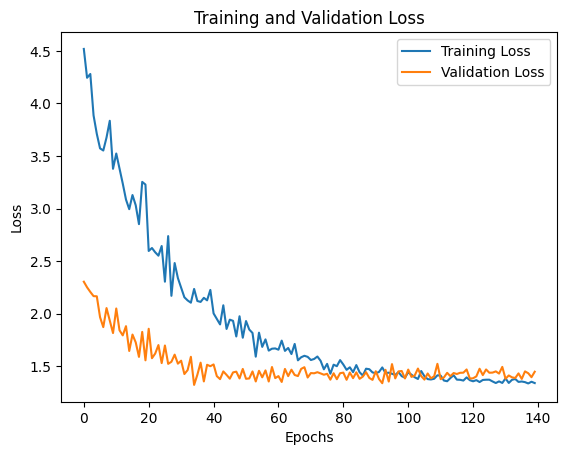

In [382]:
# Plot and label the training and validation loss values
plt.plot(losses[10:], label='Training Loss')
plt.plot(valid_losses[10:], label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Display the plot
plt.legend(loc='best')
plt.show()


Training Confusion Matrices


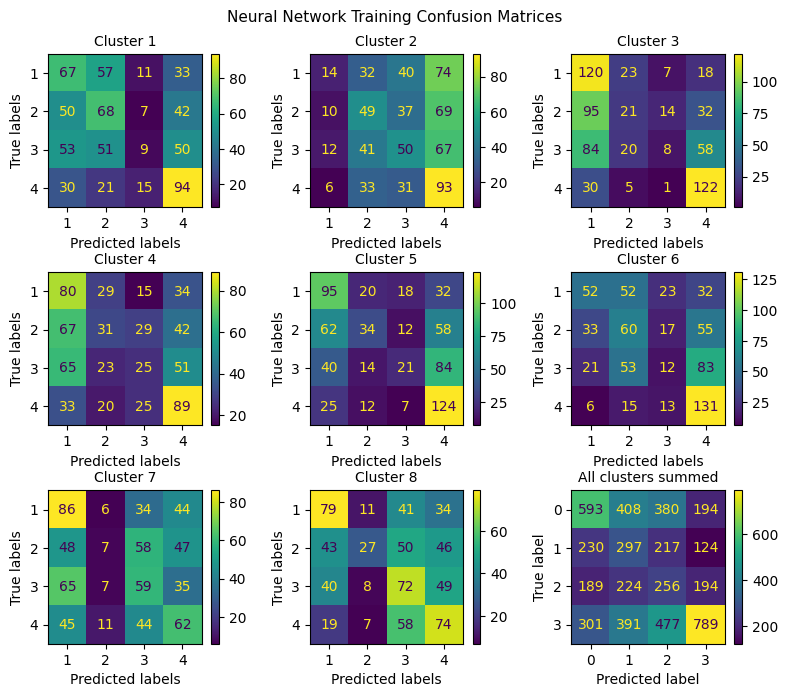

Testing Confusion Matrices


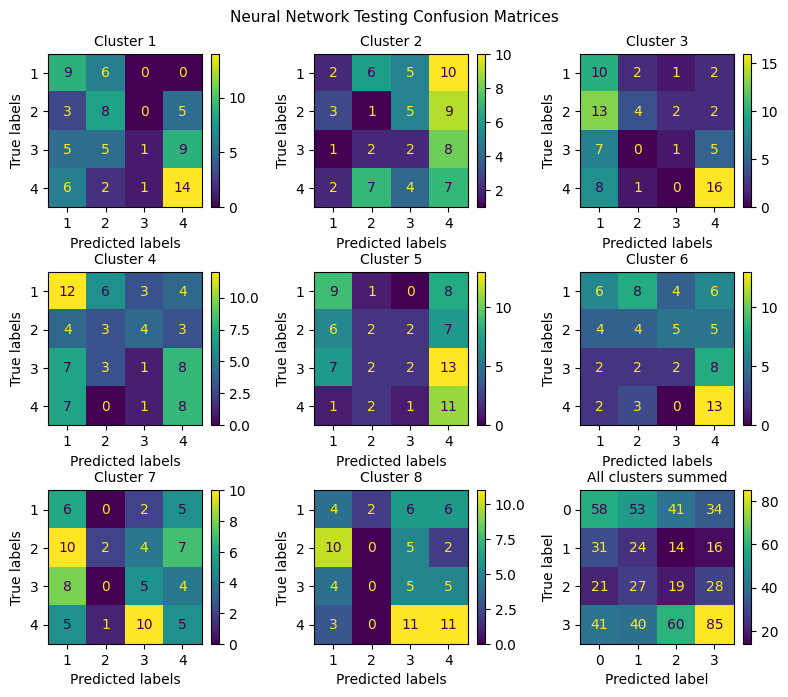

In [405]:
print("Training Confusion Matrices")
plot_confusion_matrices(nn_train_predictions_all_clusters,nn_train_labels_all_clusters,title="Neural Network Training Confusion Matrices")
print("Testing Confusion Matrices")
plot_confusion_matrices(nn_test_predictions_all_clusters,nn_test_labels_all_clusters, title="Neural Network Testing Confusion Matrices")
